# \[WIP] Exploratory Data Analysis for Data Driven Modelling

Welcome to using the data-driven jupyter notebook for evaluating datasets for building simulators in preparation of Machine Teaching with [Project Bonsai](https://docs.microsoft.com/en-us/bonsai/)! 

The goal of this repository is to help you with learning state transitions,  $(s_t, a_t) \to s_{t+1}$ from existing data. While this approach is growing in popularity its vitality depends on the _reliability_ and _coverage_ of your dataset. Our approach makes some key assumptions:

- The dataset contains:
    * States
    * Actions
    * Configs (optional)
    * Episode labels
    * Iteration labels
- All columns are numeric (or can be casted to numeric)
- Episodes always start with iteration 0
- There are no gaps in iterations within an episode

## Notebook Goals

The primary goals of this notebook are to:

1. Help you familiarize you with your data
2. Check if the data from your csv file(s) are sufficient for creating simulators using supervised learning methods
3. View any anamolies in your datasets that need preprocessing or correction
4. Format the data in a form ready for simulator building

## Recipe for Validation

Here is a recipe for validating the dataset you are using for data-driven simulator building.

1. View data-types and ranges for all variables in your dataset
2. Ensure data-completeness in terms of iteration-level samples
3. View distributional support or coverage of states, actions and configs
4. Check or anamolies or NULLs, and apply any necessary preprocessors or transformations
5. Save any transformed data and the transformation functions to appropriate folders for data-driven simulator training

### Library Imports

### TODOs:
1. Move readers to `loaders.py`
2. Update `conf` with new [`package` declaration](https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive/)

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic_dd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
from hydra.experimental import compose, initialize_config_dir
from omegaconf import OmegaConf

sns.set_context(rc={"grid.linewidth": 0})

### Sets Import Directory for Configurations

In [2]:
dir_path = os.path.dirname(os.getcwd())
os.chdir(dir_path)
# Reads the config file
with initialize_config_dir(config_dir=os.path.join(dir_path, "conf")):
    cfg = compose(config_name="config", overrides=[])

/Users/alizaidi-msft/miniconda3/envs/ddm/lib/python3.7/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive data/cartpole_st1_at.yaml in file:///Users/alizaidi-msft/Documents/bonsai/datadrivenmodel/conf.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning)
/Users/alizaidi-msft/miniconda3/envs/ddm/lib/python3.7/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive model/SVR.yaml in file:///Users/alizaidi-msft/Documents/bonsai/datadrivenmodel/conf.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning)
/Users/alizaidi-msft/miniconda3/envs/ddm/lib/python3.7/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive simulator/gboost_cartpole.yaml in file:///Users/alizaidi-msft/Documents/bonsai/datadrivenmodel/conf.
See https://hydra.cc

In [3]:
# Generates the data path
data_path = os.path.join(dir_path, cfg["data"]["path"])
# Reads into a pandas dataframe
df = pd.read_csv(data_path)
# Prints 5 random rows
df.sample(5)

,state_x_position,state_x_velocity,state_angle_position,state_angle_velocity,action_command,config_length,config_masspole,episode,iteration
482207,0.089244,0.041888,-0.108937,-0.205023,0,0.5,0.1,9644,7
287157,-0.029494,-0.013681,0.093149,0.080983,1,0.5,0.1,5743,7
468424,0.208036,-0.176210,-0.397792,-0.831968,0,0.5,0.1,9368,24
290416,-0.058716,-0.202770,0.044715,0.362384,1,0.5,0.1,5808,16
492082,0.041047,0.222165,-0.283661,-1.414000,0,0.5,0.1,9841,32


In [4]:
cfg

{'data': {'path': 'csv_data/cartpole-log.csv', 'full_or_relative': 'relative', 'inputs': 'state', 'outputs': 'state', 'augmented_cols': ['config_length', 'config_masspole', 'action_command'], 'iteration_order': -1, 'episode_col': 'episode', 'iteration_col': 'iteration', 'max_rows': 1000, 'scale_data': True}, 'model': {'name': 'SVR', 'build_params': [{'model_type': 'SVR'}, {'num_trees': 50}, {'objective': 'reg:squarederror'}, {'step_size': 0.3}, {'device': 'cpu'}, {'batch_size': 128}, {'gamma': 0}, {'scale_data': True}, {'lambda': 1}, {'max_bin': 256}], 'saver': [{'filename': 'models/moab/SVR_model'}], 'sweep': [{'run': False}, {'search_algorithm': 'bayesian'}, {'num_trials': 3}, {'scoring_func': 'r2'}]}, 'simulator': {'states': ['state_x_position', 'state_x_velocity', 'state_angle_position', 'state_angle_velocity'], 'actions': ['action_command'], 'configs': ['config_length', 'config_masspole'], 'policy': 'bonsai'}}

In [5]:
# Saves a record of episode counts pre removal of nulls
init_episode_count = df["episode"].nunique()
# Converts all columns to numeric
df = df.apply(pd.to_numeric, errors="coerce")
# Removes rows with null values
df.dropna(inplace=True)
# Calculates episode counts
episodes = (
    df.groupby("episode")
    .agg(
        first_iteration=("iteration", "min"),
        last_iteration=("iteration", "max"),
        iteration_count=("iteration", "count"),
    )
    .reset_index(drop=True)
)
# Valid episodes are where the first iteration is 0 and there are no gaps in iterations
valid_episodes = episodes.index[
    episodes["first_iteration"]
    == 0
    & (
        episodes["last_iteration"] - episodes["first_iteration"] + 1
        == episodes["iteration_count"]
    )
]
# Drops all rows with invalid episodes
df.drop(df.loc[~df["episode"].isin(valid_episodes)].index, inplace=True)
# Resets the index
df.reset_index(drop=True, inplace=True)
# Print
print("Removed {} invalid episode(s)".format(init_episode_count - len(valid_episodes)))

Removed 0 invalid episode(s)


In [6]:
# Prints basic counts
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])
print("Number of episodes:", df["episode"].nunique())
# Calculates Episode Lengths (max value of 'iteration')
episode_lengths = df.groupby("episode")["iteration"].count()
print("Shortest episode: {} iteration(s)".format(episode_lengths.min()))
print("Longest episode: {} iteration(s)".format(episode_lengths.max()))

Number of rows: 500000
Number of columns: 9
Number of episodes: 10000
Shortest episode: 50 iteration(s)
Longest episode: 50 iteration(s)


In [7]:
# States (modify if states don't start with 'state')
state_vars = [x for x in df.columns if x.startswith("state")]
# Actions (modify if actions don't start with 'action')
action_vars = [x for x in df.columns if x.startswith("action")]
# Configs (modify if configs don't start with 'config')
config_vars = [x for x in df.columns if x.startswith("config")]

print(
    "Dataset contains: {} state(s), {} action(s) and {} config(s)".format(
        len(state_vars), len(action_vars), len(config_vars)
    )
)

Dataset contains: 4 state(s), 1 action(s) and 2 config(s)


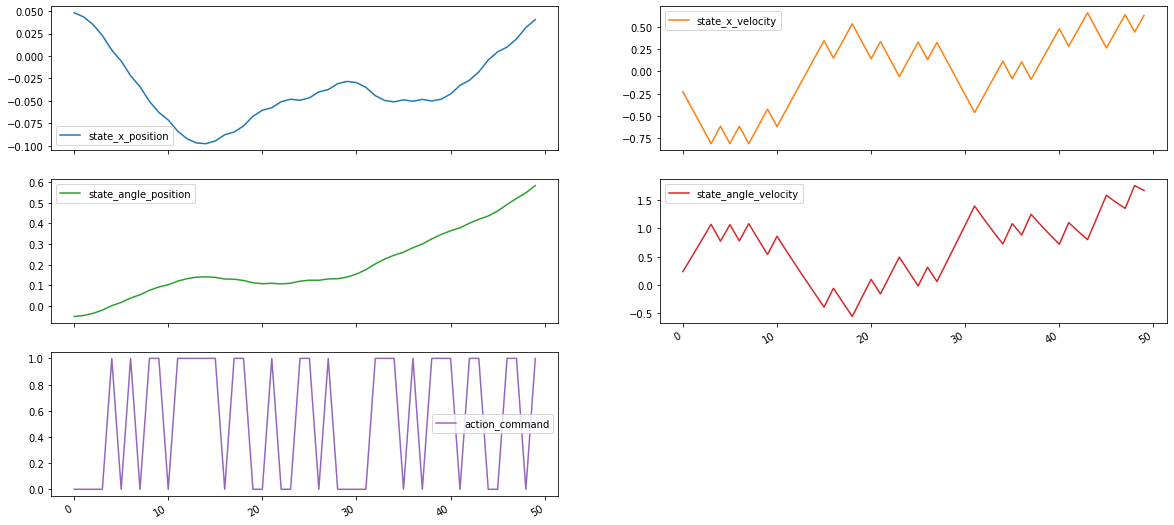

In [8]:
# Plots states and actions of a random episode
random_episode = random.choice(df["episode"])
random_day_data = df.loc[
    df["episode"] == random_episode, state_vars + action_vars
].reset_index(drop=True)
random_day_data.plot(subplots=True, figsize=(20, 10), layout=(-1, 2));

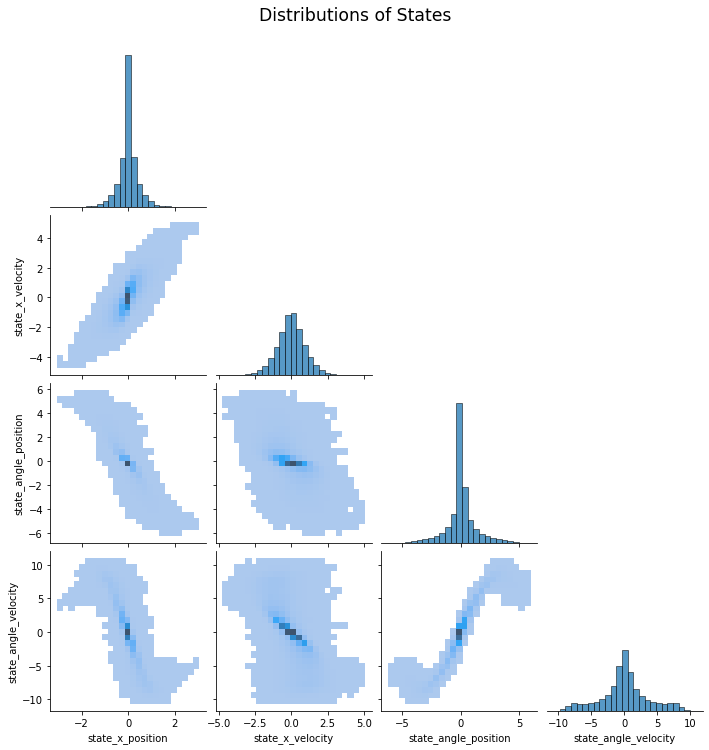

In [9]:
# Plots the distributions of States
g = sns.pairplot(
    df[state_vars],
    kind="hist",
    diag_kind="hist",
    corner=True,
    plot_kws={"bins": 25},
    diag_kws={"bins": 25},
)
g.fig.suptitle("Distributions of States", size="xx-large", y=1.04);

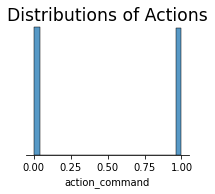

In [10]:
# Plots the distributions of Actions
g = sns.pairplot(
    df[action_vars],
    kind="hist",
    diag_kind="hist",
    corner=True,
    plot_kws={"bins": 25},
    diag_kws={"bins": 25},
)
g.fig.suptitle("Distributions of Actions", size="xx-large", y=1.04);

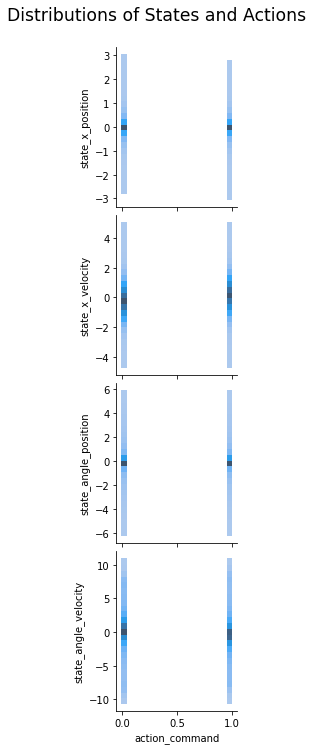

In [11]:
# Plots the distributions of States and Actions
g = sns.pairplot(
    df,
    x_vars=action_vars,
    y_vars=state_vars,
    kind="hist",
    diag_kind=None,
    plot_kws={"bins": 25},
)
g.fig.suptitle("Distributions of States and Actions", size="xx-large", y=1.04);

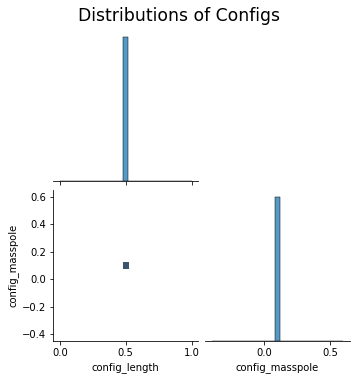

In [12]:
g = sns.pairplot(
    df[config_vars],
    kind="hist",
    diag_kind="hist",
    corner=True,
    plot_kws={"bins": 25},
    diag_kws={"bins": 25},
)
g.fig.suptitle("Distributions of Configs", size="xx-large", y=1.04);

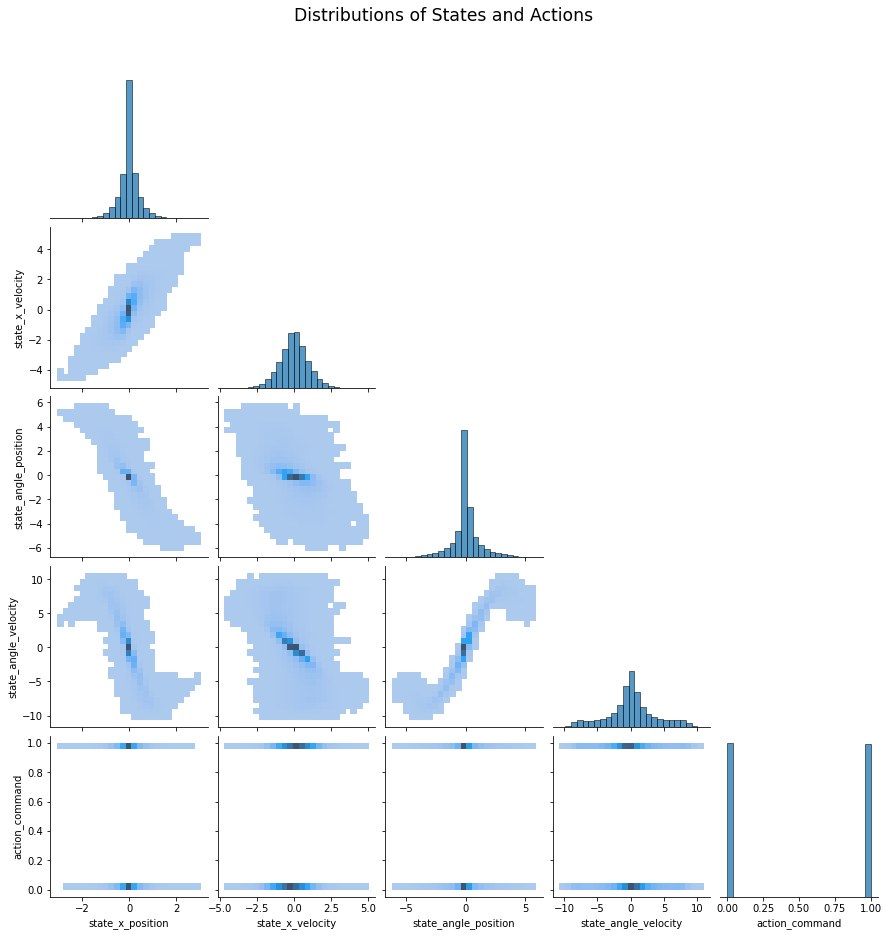

In [13]:
g = sns.pairplot(
    df[state_vars + action_vars],
    kind="hist",
    diag_kind="hist",
    corner=True,
    plot_kws={"bins": 25},
    diag_kws={"bins": 25},
)
g.fig.suptitle("Distributions of States and Actions", size="xx-large", y=1.04);

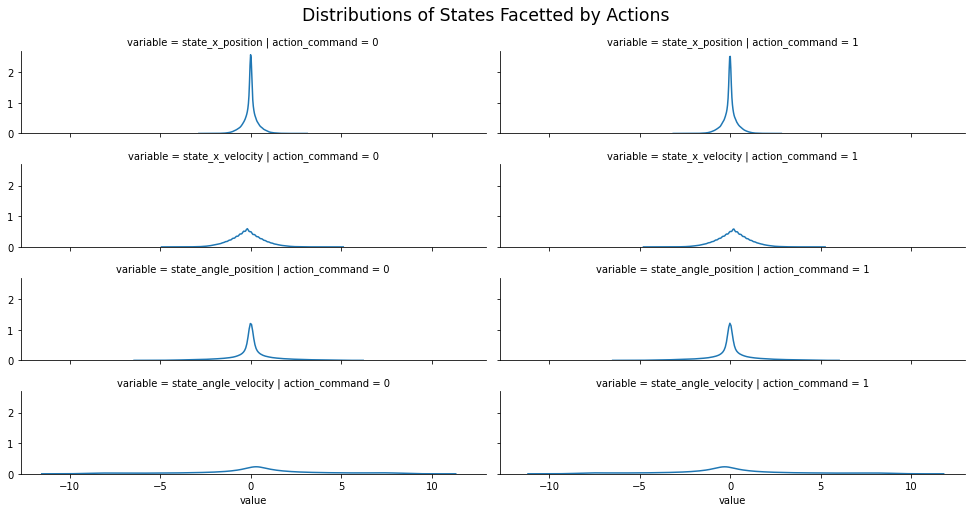

In [14]:
g = sns.FacetGrid(
    df[state_vars + action_vars].melt(id_vars="action_command"),
    col="action_command",
    row="variable",
    height=1.7,
    aspect=4,
    
)

g.map(sns.kdeplot, "value")
g.fig.suptitle("Distributions of States Facetted by Actions", size="xx-large", y=1.04);